# 📍 Pick Points

Herbie's `pick_points` xarray accessor picks data from a model grid nearest locations of interest. Think of it like picking apples from a tree. Herbie's implementation uses the **scikit-learn** BallTree algorithm with the haversine formula to get nearest-neighbor values. The haversine formula is important when working with latitude and longitude coordinates.

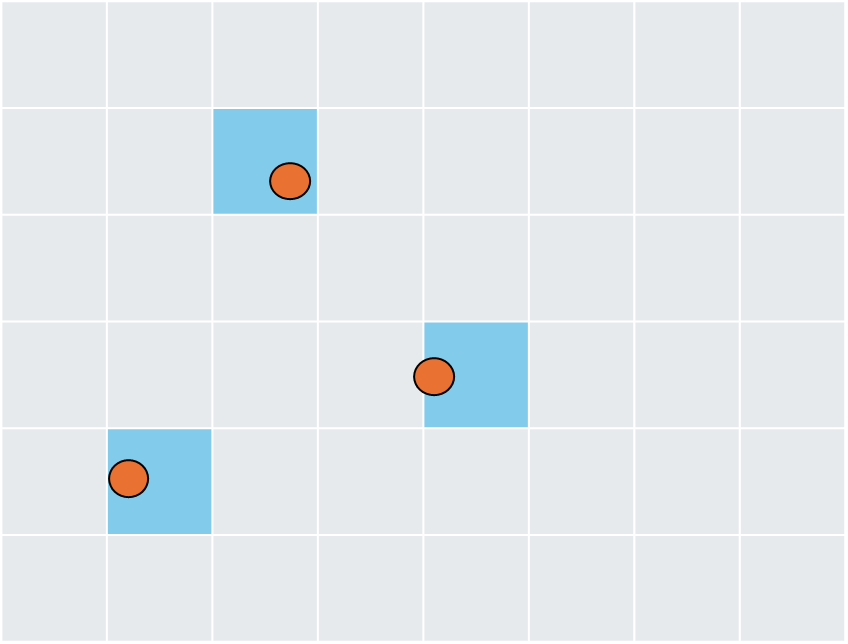

For regular latitude-longitude grids (e.g., GFS, IFS), you could use xarray's [advanced indexing](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing) instead to easily select your points of interest, but that solution doesn't work in the following cases:

- Models with curvilinear grids (i.e. not a regular latitude-longitude grid);
- Longitude units, `[0, 360)` vs `[-180, 180)`, differ between model and requested point.
- The distance to the nearest neighbor needs to be known.
- Picking more than one nearest neighbor points.

<details>

Picking values at nearest-neighbor points in a [curvilinear grid](https://en.wikipedia.org/wiki/Curvilinear_coordinates) has been one of my longstanding questions. In November 2019, I asked [How to select the nearest lat/lon location with multi-dimension coordinates)](https://stackoverflow.com/q/58758480/2383070) on Stack Overflow, which has had over 28k views in four years. I suggested a rudimentary solution that determined the nearest neighbor point by finding the absolute minimum value between the point and grid difference, but this solution didn't scale well for picking many points.

I iterated over different solutions since then.

In the deprecated Herbie accessor `ds.herbie.nearest_points`, I used MetPy's [assign_y_x](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x), transformed the latitude and longitude points to the coordinate reference system coordinates (e.g. lambert conformal for HRRR), and then picked the nearest neighbor points. That worked fine, but it required a coordinate transformation by Cartopy, and not all xarray Datasets have sufficient information to determine the appropriate coordinate transformation.

This new approach using BallTree, we don't need to do a coordinate transformation, we can pick the $k$-th nearest neighbors, and the distance to the nearest neighbors (haversine formula) is returned. I have also implemented the capability to compute the inverse-distance weighted mean of the four (or more) grid points nearest your points of interest.

As I write this, I learned about the [xoak](https://xoak.readthedocs.io/) package, which also uses BallTree to query nearest neighbors.

<hr>

</details>

<br>

Let's get started...

To use Herbie's xarray accessors, you just need to import anything from Herbie.


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import herbie
from herbie import FastHerbie, Herbie

## A Very Simple Demonstration

First, I'll show how Herbie extracts nearest points from a simple grid. Let's make a 3x3 xarray Dataset with latitude/longitude coordinates and then extract data nearest two points of interest.


In [2]:
# Create a 3x3 xarray dataset
ds = xr.Dataset(
    {"a": (["latitude", "longitude"], [[0, 1, 2], [0, 1, 0], [0, 0, 0]])},
    coords={
        "latitude": (["latitude"], [44, 45, 46]),
        "longitude": (["longitude"], [-99, -100, -101]),
    },
)
ds

<xarray.Dataset> Size: 120B
Dimensions:    (latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) int64 24B 44 45 46
  * longitude  (longitude) int64 24B -99 -100 -101
Data variables:
    a          (latitude, longitude) int64 72B 0 1 2 0 1 0 0 0 0

The points you want to extract must be given as a Pandas DataFrame with columns `latitude` and `longitude` given in degrees.


In [3]:
# We want to pick data closest to two points
points = pd.DataFrame(
    {
        "longitude": [-100.25, -99.4],
        "latitude": [44.25, 45.4],
    }
)
points

,longitude,latitude
0,-100.25,44.25
1,-99.40,45.40


Now we can pick the nearest grid points with the custom Herbie xarray accessor.

> Note `method='nearest'` is the default behavior.


In [4]:
# Pick the value nearest the requested points
matched = ds.herbie.pick_points(points, method="nearest")
matched

         Provide tree_name parameter to enable caching.
INFO: 🌱 Growing new BallTree...

🌳 Complete in 0.01s


<xarray.Dataset> Size: 96B
Dimensions:              (point: 2)
Coordinates:
    latitude             (point) int64 16B 44 45
    longitude            (point) int64 16B -100 -99
    point_grid_distance  (point) float64 16B 34.22 54.41
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
Dimensions without coordinates: point
Data variables:
    a                    (point) int64 16B 1 0

Alternatively, we can get the inverse-distance weighted mean of the 4 nearest points.


In [5]:
# Distance weighted mean
matched_w = ds.herbie.pick_points(points, method="weighted")
matched_w

         Provide tree_name parameter to enable caching.
INFO: 🌱 Growing new BallTree...🌳 Complete in 0.00s


<xarray.Dataset> Size: 240B
Dimensions:              (point: 2, k: 4)
Coordinates:
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
    latitude             (k, point) int64 64B 44 45 44 45 45 46 45 46
    longitude            (k, point) int64 64B -100 -99 -101 ... -99 -101 -100
    point_grid_distance  (k, point) float64 64B 34.22 54.41 66.0 ... 102.4 81.38
Dimensions without coordinates: point, k
Data variables:
    a                    (point) float64 16B 1.082 0.2588
Attributes:
    pick_point_method:  weighted
    pick_point_k:       4

That's a lot of info to digest. I'll help you visualize what we have done with the following figure.


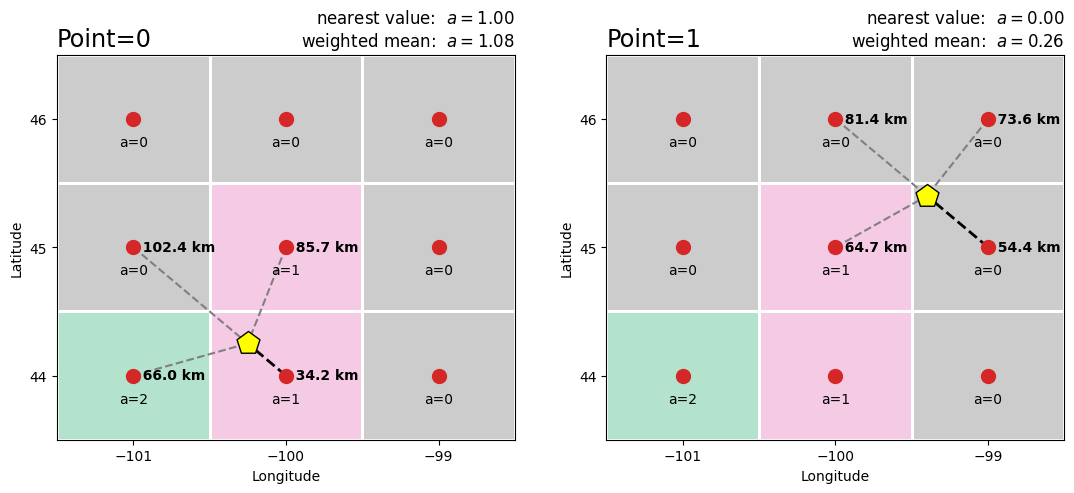

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[13, 5])
for p, ax in zip(matched_w.point, axes):
    zz = matched.sel(point=p)

    # Plot grid
    ax.pcolormesh(
        ds.longitude, ds.latitude, ds.a, edgecolor="1", lw=1, cmap="Pastel2_r"
    )
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    x = x.flatten()
    y = y.flatten()
    ax.scatter(x, y, facecolor="tab:red", edgecolor="tab:red", s=100, zorder=100)

    # Plot requested point
    ax.scatter(
        zz.point_longitude,
        zz.point_latitude,
        color="yellow",
        ec="k",
        marker="p",
        s=300,
        zorder=100,
    )
    for i in ds.latitude:
        for j in ds.longitude:
            z = ds.sel(latitude=i, longitude=j)
            ax.text(j, i, f"\na={z.a.item()}", ha="center", va="top")

    # Plot path to nearest point and distance
    # for i, j in zip(x, y):
    #    ax.plot([i, point.longitude.values[0]], [j, point.latitude.values[0]])
    for i in matched_w.k:
        if i == 0:
            kwargs = dict(lw=2, color="k", ls="--")
        else:
            kwargs = dict(color=".5", ls="--")
        z = matched_w.sel(k=i, point=p)
        ax.plot(
            [z.longitude, z.point_longitude], [z.latitude, z.point_latitude], **kwargs
        )
        ax.text(
            z.longitude,
            z.latitude,
            f"  {z.point_grid_distance.item():.1f} km",
            va="center",
            fontweight="bold",
        )
    ax.set_xticks(ds.longitude)
    ax.set_yticks(ds.latitude)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Point={p.item()}", loc="left", fontsize="xx-large")
    ax.set_title(
        f"nearest value:  $a={zz.a.item():.2f}$\nweighted mean:  $a={z.a.item():.2f}$",
        loc="right",
    )

The yellow pentagon is the requested point. The grid's nearest-neighbor point is connected by a thick dashed line. The three other nearest neighbors used to compute the distance-weighted mean are connected by a thin dashed line.

**Summary:** From a simple 2D Dataset with latitude and longitude coordinates, we got the nearest value for two points of interest. We also compute the inverse-distance weighted mean from the four grids nearest our point of interest.


## Pick points from HRRR data

The above is nice, but you might say, "Yeah, but you can already select data from a grid using [xarray advanced selection](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing)." That is true, but it does not work for models with curvilienar grids, like the HRRR model.

Here is a demonstration using real HRRR data.


In [7]:
H = Herbie("2024-03-01", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


<xarray.Dataset> Size: 46MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.5 292.5 292.4 ... 266.8 266.8
    d2m                  (y, x) float32 8MB 287.3 287.2 287.2 ... 262.2 262.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Let's extract the data from some points with some fruit-themed station id names.


In [8]:
points = pd.DataFrame(
    {
        "latitude": np.linspace(44, 45.5, 5),
        "longitude": np.linspace(-100, -101, 5),
        "stid": ["McIntosh", "Golden", "Fuji", "Gala", "Honeycrisp"],
    }
)
points

,latitude,longitude,stid
0,44.000,-100.00,McIntosh
1,44.375,-100.25,Golden
2,44.750,-100.50,Fuji
3,45.125,-100.75,Gala
4,45.500,-101.00,Honeycrisp


In [9]:
%%time
matched = ds.herbie.pick_points(points)
matched

CPU times: user 267 ms, sys: 1.64 s, total: 1.91 s
Wall time: 1.91 s


<xarray.Dataset> Size: 320B
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 40B 43.99 44.37 44.76 45.13 45.5
    longitude            (point) float64 40B 260.0 259.8 259.5 259.3 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 40B 0.8515 1.07 1.611 1.41 1.318
    point_latitude       (point) float64 40B 44.0 44.38 44.75 45.12 45.5
    point_longitude      (point) float64 40B -100.0 -100.2 -100.5 -100.8 -101.0
    point_stid           (point) object 40B 'McIntosh' 'Golden' ... 'Honeycrisp'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 20B 288.0 286.7 286.1 282.3 284.8
    d2m                  (point) float32 20B 268.8 271.8 270.5 274.1 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Notice that a BallTree object for the HRRR model was saved with the name `<model_name>_<x_dim>_<y_dim>.pkl` in the directory you save Herbie data. This is done so it can be loaded more quickly next time you extract points from this grid.

In the next cell I run the same command, and it uses the cached tree instead.


In [10]:
%%time
matched = ds.herbie.pick_points(points)
matched

CPU times: user 367 ms, sys: 189 ms, total: 556 ms
Wall time: 555 ms


<xarray.Dataset> Size: 320B
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 40B 43.99 44.37 44.76 45.13 45.5
    longitude            (point) float64 40B 260.0 259.8 259.5 259.3 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 40B 0.8515 1.07 1.611 1.41 1.318
    point_latitude       (point) float64 40B 44.0 44.38 44.75 45.12 45.5
    point_longitude      (point) float64 40B -100.0 -100.2 -100.5 -100.8 -101.0
    point_stid           (point) object 40B 'McIntosh' 'Golden' ... 'Honeycrisp'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 20B 288.0 286.7 286.1 282.3 284.8
    d2m                  (point) float32 20B 268.8 271.8 270.5 274.1 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

You may want to swap the dimensions to use the `point_stid` coordinate as the dimension instead. Doing this makes it possible to select data by station ID instead of point index.


In [11]:
matched = matched.swap_dims({"point": "point_stid"})
matched.sel(point_stid="Honeycrisp")

<xarray.Dataset> Size: 128B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             float64 8B 45.5
    longitude            float64 8B 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  float64 8B 1.318
    point_latitude       float64 8B 45.5
    point_longitude      float64 8B -101.0
    point_stid           <U10 40B 'Honeycrisp'
Data variables:
    t2m                  float32 4B 284.8
    d2m                  float32 4B 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Now let's plot each point on a map with the value at the nearest grid point.


(-289442.889311017, -108684.3334160587, 605320.486730601, 849853.0858732163)

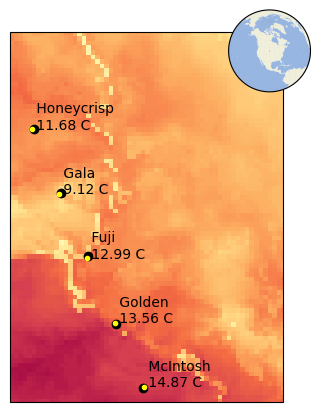

In [12]:
from herbie.toolbox import EasyMap, ccrs, pc

ax = EasyMap(crs=ds.herbie.crs).ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m,
    cmap="Spectral_r",
    vmax=290,
    vmin=270,
    transform=pc,
)

for i in matched.point_stid:
    z = matched.sel(point_stid=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_stid.item()}\n {z.t2m.item() - 273.15:.2f} C",
        transform=pc,
    )
ax.set_extent([-101, -99, 44, 46], crs=pc)
ax.EasyMap.INSET_GLOBE()
ax.adjust_extent()

## Pick Points: Sounding

If you want a "sounding" at a single point, you will need to get the GRIB data for all the model layers of interest (yes, that's a lot of data), then pick the point.


In [13]:
# TODO: Get real sounding data to compare model data to.

In [14]:
H = Herbie("2024-03-28 00:00", model="hrrr", product="prs")
ds = H.xarray("(?:DPT|TMP):[0-9]* mb", remove_grib=False)

# Get HRRR sounding at Salt Lake City
slc = ds.herbie.pick_points(
    pd.DataFrame({"latitude": [40.76], "longitude": [-111.876183]})
)
slc

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 696B
Dimensions:              (isobaricInhPa: 39, point: 1)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 312B 1e+03 975.0 ... 75.0 50.0
    latitude             (point) float64 8B 40.75
    longitude            (point) float64 8B 248.1
    valid_time           datetime64[ns] 8B 2024-03-28
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 8B 1.193
    point_latitude       (point) float64 8B 40.76
    point_longitude      (point) float64 8B -111.9
Dimensions without coordinates: point
Data variables:
    t                    (isobaricInhPa, point) float32 156B ...
    dpt                  (isobaricInhPa, point) float32 156B ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 prs
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befd2f...
    search:                  (?:DPT|TMP):[0-9]* mb

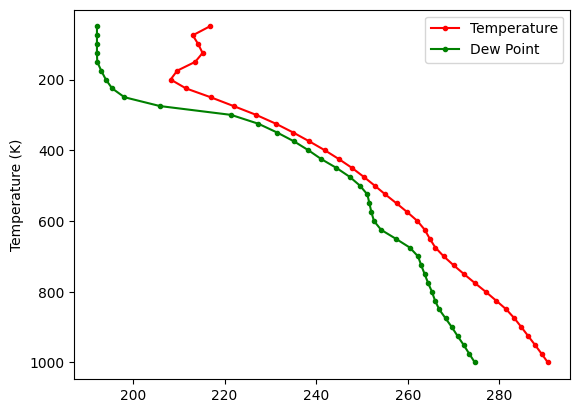

In [15]:
# TODO: plot data on a sounding plot using MetPy

ax = plt.gca()
ax.plot(slc.t, slc.isobaricInhPa, color="red", marker=".", label="Temperature")
ax.plot(slc.dpt, slc.isobaricInhPa, color="green", marker=".", label="Dew Point")
ax.invert_yaxis()
ax.set_ylabel("Level (hPa)")
ax.set_ylabel("Temperature (K)")
ax.legend()

## Pick Points: Timeseries


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 15:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 21:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


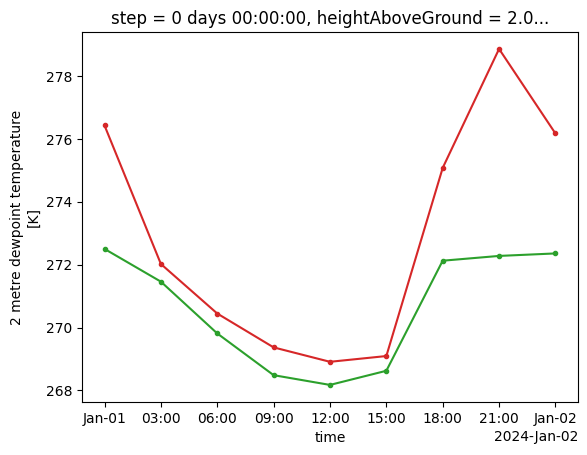

In [16]:
# TODO: Could demonstrate using FastHerbie here, if the kernel wouldn't crash (memory??)

i = []
for date in pd.date_range("2024-01-01", periods=9, freq="3h"):
    ds = Herbie(date).xarray("(?:DPT|TMP):2 m")
    i.append(
        ds.herbie.pick_points(
            pd.DataFrame(
                {
                    "latitude": [40.77069],
                    "longitude": [-111.96503],
                    "stid": ["KSLC"],
                }
            )
        )
    )
slc_ts = xr.concat(i, dim="valid_time")

slc_ts.t2m.plot(x="valid_time", marker=".", color="tab:red")
slc_ts.d2m.plot(x="valid_time", marker=".", color="tab:green")

## Benchmark

Let's see how fast `ds.herbie.pick_points` is for harvesting _many_ points...


In [14]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from herbie import Herbie
from herbie.toolbox import EasyMap, ccrs, pc

In [15]:
H = Herbie("2024-03-28 00:00", model="hrrr")
ds = H.xarray(r"TMP:\d* mb", remove_grib=False)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


Using the model's own grid, I will generate 100 random samples to extract.


In [16]:
def generate_random_string(len=8):
    """Generate a random string."""
    import random
    import string

    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 100
points_self = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points_self["stid"] = [generate_random_string() for _ in range(n)]
points_self

,latitude,longitude,stid
0,50.957734,276.450430,g2FyhTRH
1,51.741188,266.854037,4hc7nbVW
2,41.074728,266.499187,QWyMlZY8
3,43.276620,250.086372,NMvXVViO
4,40.710723,240.446769,DJp2y7JY
...,...,...,...
95,25.305948,241.867219,BYF9lUnb
96,25.465298,282.206874,wHpTovGc
97,26.846124,252.932130,nDDz44xa
98,26.552311,264.680946,7BTqAi7q


In [4]:
%%timeit
y1 = ds.herbie.pick_points(points_self)

548 ms ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
y2 = ds.herbie.pick_points(points_self, method="weighted")

1.52 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
# Try the deprecated `nearest_points` method which used MetPy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y3 = ds.herbie.nearest_points(points_self)

446 ms ± 83.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Do I get the same answer for the old and new method?
y1 = ds.herbie.pick_points(points_self)
y2 = ds.herbie.pick_points(points_self, method="weighted")
y3 = ds.herbie.nearest_points(points_self)

all(y1.latitude == y3.latitude), all(y1.longitude == y3.longitude)

/home/blaylock/GITHUB/Herbie/src/herbie/nearest_points.py:109: UserWarning: More than one time coordinate present for variable  "t".
  ds = ds.metpy.assign_y_x()


(True, True)

CPU times: user 1.14 s, sys: 152 ms, total: 1.29 s
Wall time: 1.29 s


<GeoAxes: label='inset_axes'>

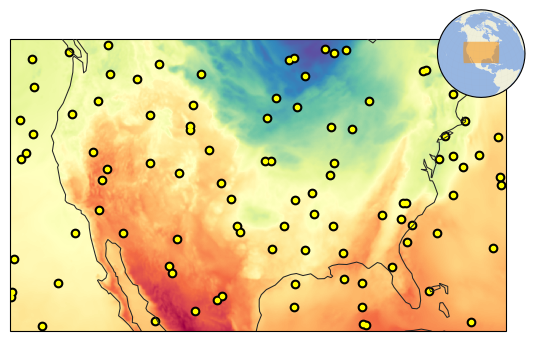

In [10]:
%%time
ax = EasyMap(crs=ds.herbie.crs).ax

ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.isel(isobaricInhPa=0).t,
    cmap="Spectral_r",
    transform=pc,
)

ax.scatter(y1.longitude, y1.latitude, color="k", transform=pc)
ax.scatter(
    y1.point_longitude, y1.point_latitude, color="yellow", marker=".", transform=pc
)

ax.EasyMap.INSET_GLOBE()

Not bad. Less than half a second to extract 100 points from the HRRR grid.

Now let's try _even more_...


CPU times: user 1min 46s, sys: 36.3 s, total: 2min 22s
Wall time: 2min 23s


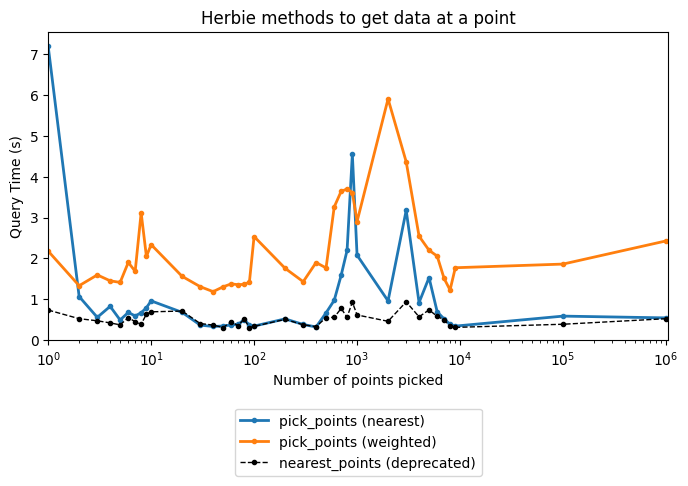

In [15]:
%%time

n_samples = (
    [1, 2, 3, 4, 5, 6, 7, 8, 9]
    + list(range(10, 100, 10))
    + list(range(100, 1_000, 100))
    + list(range(1_000, 10_000, 1_000))
    + [100_000, 1_000_000]
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Timers for nearest_points (deprecated)
    times_np = []
    samples_np = []

    # Timers for pick_points method='nearest'
    times_pp = []
    samples_pp = []

    # Timers for pick_points method='weighted'
    times_w = []
    samples_w = []

    for s in n_samples:
        samples_np.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.nearest_points(points_self)
        times_np.append((pd.Timestamp("now") - timer).total_seconds())

        samples_pp.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.pick_points(points_self, method="nearest")
        times_pp.append((pd.Timestamp("now") - timer).total_seconds())

        samples_w.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.pick_points(points_self, method="weighted")
        times_w.append((pd.Timestamp("now") - timer).total_seconds())


plt.figure(figsize=[8, 4])
plt.plot(
    samples_pp,
    times_pp,
    marker=".",
    lw=2,
    color="tab:blue",
    label="pick_points (nearest)",
)
plt.plot(
    samples_w,
    times_w,
    marker=".",
    lw=2,
    color="tab:orange",
    label="pick_points (weighted)",
)
plt.plot(
    samples_np,
    times_np,
    marker=".",
    lw=1,
    color="k",
    ls="--",
    label="nearest_points (deprecated)",
)

plt.title("Herbie methods to get data at a point")
plt.xlabel("Number of points picked")
plt.ylabel("Query Time (s)")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.legend(loc="upper center", bbox_to_anchor=[0.5, -0.2])
plt.gca().set_xscale("log")

Nice! This BallTree method used by `pick_points()` scales well for harvesting _many_ points 😎

Lets see how well this works for the GFS model...


In [16]:
gfs = Herbie("2024-01-01", model="gfs").xarray(":TMP:2 m ")

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [17]:
%%time
gfs.herbie.pick_points(points_self)

CPU times: user 472 ms, sys: 403 ms, total: 875 ms
Wall time: 888 ms


<xarray.Dataset> Size: 5kB
Dimensions:              (point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 800B 29.0 47.0 34.0 ... 43.5 34.5 32.25
    longitude            (point) float64 800B 288.8 265.0 260.2 ... 243.5 264.0
    valid_time           datetime64[ns] 8B 2024-01-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 800B 12.02 12.89 13.02 ... 4.895 10.7
    point_latitude       (point) float64 800B 29.07 46.91 33.92 ... 34.46 32.27
    point_longitude      (point) float64 800B 288.8 265.1 260.4 ... 243.5 264.1
    point_stid           (point) object 800B 'vs19baF1' ... 'WoofWdoE'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 400B 293.3 267.1 280.0 ... 284.3 287.3
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gfs
    product:                 pgrb2.0p25
    description:             NOAA Global Forecast System (GFS)
    remote_grib:             https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20...
    local_grib:              /home/blaylock/data/gfs/20240101/subset_6bef22b0...
    search:                  :TMP:2 m

## Advanced Options

The default behavior for `method='nearest'` is to return the first nearest neighbor. The default behavior for `method='weighted'` is to return the inverse-distance weighted mean of the nearest 4 grid points.

You can get more or fewer neighbors by setting the `k` argument. This might be useful if you want to compute the standard deviation of the _k_ grid points surrounding a point of interest.


In [13]:
%%time
# Return the 5 nearest grid points to each request point
ds.herbie.pick_points(points_self, method="nearest", k=5)

NameError: name 'points_self' is not defined

In [28]:
%%time
# Compute the distance weighted mean for the 9 nearest grid points to
# each request point
ds.herbie.pick_points(points_self, method="weighted", k=9)

CPU times: user 2.78 s, sys: 97.1 ms, total: 2.88 s
Wall time: 2.87 s


<xarray.Dataset> Size: 28kB
Dimensions:              (isobaricInhPa: 5, point: 100, k: 9)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    valid_time           datetime64[ns] 8B 2024-03-28
    gribfile_projection  object 8B None
    point_latitude       (point) float64 800B 28.12 45.43 29.33 ... 38.23 42.48
    point_longitude      (point) float64 800B 251.5 236.5 290.3 ... 256.4 268.4
    point_stid           (point) object 800B 'A4Bt4ArI' ... 'PsiEP6f0'
    latitude             (k, point) float64 7kB 28.12 45.43 ... 38.26 42.45
    longitude            (k, point) float64 7kB 251.5 236.5 ... 256.4 268.4
    point_grid_distance  (k, point) float64 7kB 0.0 0.0 0.0 ... 4.242 4.232
Dimensions without coordinates: point, k
Data variables:
    t                    (isobaricInhPa, point) float64 4kB 304.9 ... 244.0

Suppose I wanted to get the standard deviation of model surface height around each of my points.


In [17]:
ds = Herbie("2024-01-01").xarray("HGT:surface")
dsp = ds.herbie.pick_points(points_self, k=100)
dsp

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


<xarray.Dataset> Size: 282kB
Dimensions:              (k: 100, point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    latitude             (k, point) float64 80kB 50.96 51.74 ... 26.66 45.65
    longitude            (k, point) float64 80kB 276.5 266.9 ... 264.8 278.5
    valid_time           datetime64[ns] 8B 2024-01-01
    gribfile_projection  object 8B None
    point_grid_distance  (k, point) float64 80kB 0.0 0.0 0.0 ... 16.62 16.83
    point_latitude       (point) float64 800B 50.96 51.74 41.07 ... 26.55 45.73
    point_longitude      (point) float64 800B 276.5 266.9 266.5 ... 264.7 278.7
    point_stid           (point) object 800B 'g2FyhTRH' ... 'Xu2joZOi'
Dimensions without coordinates: k, point
Data variables:
    orog                 (k, point) float32 40kB 108.0 371.3 ... 0.01339 175.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240101/subset_6bef832...
    search:                  HGT:surface

In [18]:
z = dsp.orog.std(dim="k")
z

<xarray.DataArray 'orog' (point: 100)> Size: 400B
array([7.45906448e+00, 1.48826761e+01, 1.39841566e+01, 3.07691010e+02,
       3.10271271e+02, 1.06862480e+02, 3.06889725e+01, 0.00000000e+00,
       2.65254269e+01, 1.24004574e+01, 9.61592941e+01, 2.54709091e+01,
       7.88021612e+00, 0.00000000e+00, 4.14332314e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.90163345e+01, 2.34508467e+00,
       0.00000000e+00, 6.14068527e+01, 1.74823608e+01, 0.00000000e+00,
       1.71839859e+02, 1.90801220e+01, 8.67004547e+01, 0.00000000e+00,
       7.40233564e+00, 7.19284515e+01, 2.96436901e+01, 0.00000000e+00,
       2.87226227e+02, 0.00000000e+00, 3.60465393e+01, 8.72482109e+00,
       0.00000000e+00, 1.55120902e-02, 3.89144287e+01, 1.24218445e+01,
       6.81078015e-03, 2.03924957e+02, 2.78461914e+01, 0.00000000e+00,
       2.36573014e-02, 0.00000000e+00, 0.00000000e+00, 1.51959503e+02,
       0.00000000e+00, 1.58956055e+02, 2.35171402e+02, 1.90933975e+02,
       1.69787312e+01, 2.72364014e+02, 0.00000000e+00, 2.38103600e+01,
       0.00000000e+00, 1.29463100e+01, 1.69642410e+02, 9.78978062e+00,
       1.39988556e+01, 0.00000000e+00, 0.00000000e+00, 6.41575012e+01,
       0.00000000e+00, 7.83595352e+01, 6.81077968e-03, 0.00000000e+00,
       0.00000000e+00, 3.30011047e+02, 8.18039703e+00, 1.67625168e+02,
       0.00000000e+00, 1.67172127e+01, 4.28290222e+02, 6.72318420e+01,
       2.13894730e+02, 0.00000000e+00, 1.46941496e-02, 3.72876668e+00,
       5.25091438e+01, 6.18402863e+00, 2.68900879e+02, 9.15527344e-05,
       0.00000000e+00, 2.51292496e+02, 2.25579758e+02, 3.07000458e+02,
       4.38367367e+00, 2.19795044e+02, 1.26640923e+02, 6.58352203e+01,
       1.90694752e+01, 1.07676620e+02, 1.26605743e+02, 0.00000000e+00,
       3.00264239e-01, 7.69337769e+01, 0.00000000e+00, 9.15527344e-05],
      dtype=float32)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    valid_time           datetime64[ns] 8B 2024-01-01
    gribfile_projection  object 8B None
    point_latitude       (point) float64 800B 50.96 51.74 41.07 ... 26.55 45.73
    point_longitude      (point) float64 800B 276.5 266.9 266.5 ... 264.7 278.7
    point_stid           (point) object 800B 'g2FyhTRH' ... 'Xu2joZOi'
Dimensions without coordinates: point

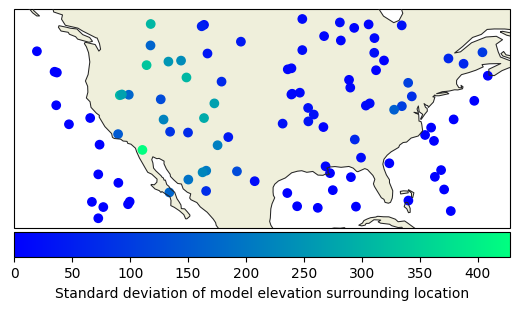

In [20]:
ax = EasyMap().LAND().ax
art = ax.scatter(z.point_longitude, z.point_latitude, c=z, cmap="winter")
plt.colorbar(
    art,
    ax=ax,
    label="Standard deviation of model elevation surrounding location",
    orientation="horizontal",
    pad=0.01,
)